<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/2024_Revnb_75_25_Update_H2_T3_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

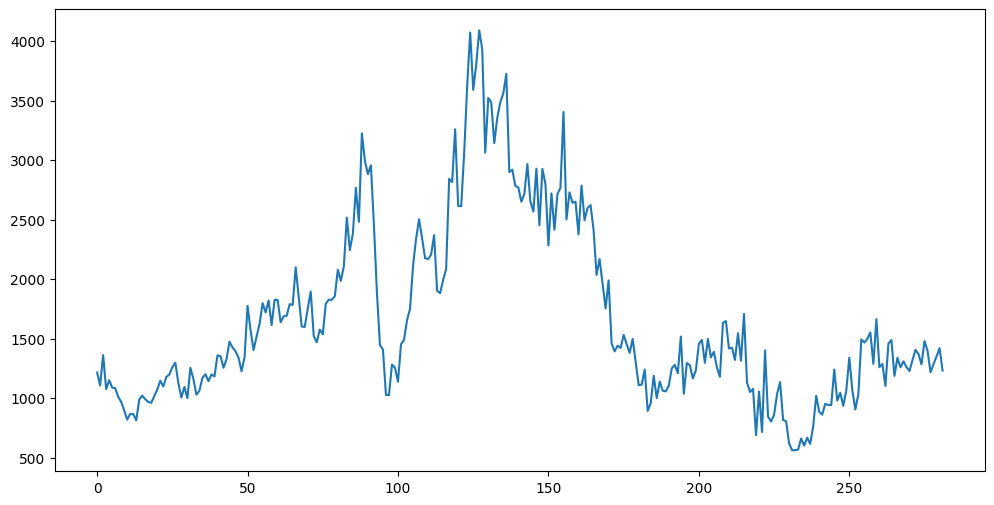

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Peramalan-LSTM_75-25/main/Ekspor-Migas-2001-2024.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 211
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 3
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (208, 3, 1)
y_train.shape:  (208, 1)
X_test.shape:  (71, 3, 1)
y_test.shape:  (71, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 05:11:43,459] A new study created in memory with name: no-name-06e6b8c5-8041-48e1-a3cf-6e70d4fa9825


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0294
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step
Fold 2: MSE = 0.0846


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
Fold 3: MSE = 0.2726
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 4: MSE = 0.0502
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 443ms/step


[I 2024-08-15 05:12:13,482] Trial 0 finished with value: 0.09267517924308777 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.09267517924308777.


Fold 5: MSE = 0.0266
Average MSE: 0.0927
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 1: MSE = 0.0085
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
Fold 2: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 3: MSE = 0.0116
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 05:12:58,469] Trial 1 finished with value: 0.00792007427662611 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0023
Average MSE: 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 2: MSE = 0.0281
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 3: MSE = 0.0635
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step


[I 2024-08-15 05:13:29,440] Trial 2 finished with value: 0.024664128199219704 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0247
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 1: MSE = 0.0172
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 2: MSE = 0.0459
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 3: MSE = 0.0410
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2024-08-15 05:14:01,342] Trial 3 finished with value: 0.02261335961520672 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0020
Average MSE: 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 1: MSE = 0.0324
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 2: MSE = 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 3: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 4: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


[I 2024-08-15 05:14:31,262] Trial 4 finished with value: 0.015425018966197968 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0020
Average MSE: 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step
Fold 1: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 2: MSE = 0.0375
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Fold 3: MSE = 0.0315
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


[I 2024-08-15 05:15:03,628] Trial 5 finished with value: 0.02044770121574402 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0024
Average MSE: 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 1: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
Fold 2: MSE = 0.0270
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 3: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
Fold 4: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 05:15:35,135] Trial 6 finished with value: 0.014497200027108192 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step
Fold 1: MSE = 0.7359
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
Fold 2: MSE = 0.1026
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
Fold 3: MSE = 0.1705
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 4: MSE = 1.6134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step


[I 2024-08-15 05:16:07,386] Trial 7 finished with value: 0.5274602174758911 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0149
Average MSE: 0.5275
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0218
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 2: MSE = 0.0355
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 3: MSE = 0.0374
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step


[I 2024-08-15 05:16:40,769] Trial 8 finished with value: 0.020546527579426765 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0020
Average MSE: 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 1: MSE = 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 2: MSE = 0.0590
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.2099
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
Fold 4: MSE = 0.0358
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step


[I 2024-08-15 05:17:06,545] Trial 9 finished with value: 0.07191313803195953 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0277
Average MSE: 0.0719
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 1: MSE = 0.0267
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0116
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 4: MSE = 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


[I 2024-08-15 05:17:40,905] Trial 10 finished with value: 0.01282607764005661 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0023
Average MSE: 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step
Fold 1: MSE = 0.0204
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 2: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
Fold 3: MSE = 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 4: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2024-08-15 05:18:21,483] Trial 11 finished with value: 0.01103096455335617 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0025
Average MSE: 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 1: MSE = 0.0255
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 2: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 3: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 4: MSE = 0.0072
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2024-08-15 05:18:56,739] Trial 12 finished with value: 0.01249179057776928 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0028
Average MSE: 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
Fold 1: MSE = 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step
Fold 2: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
Fold 3: MSE = 0.0278
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 05:19:35,181] Trial 13 finished with value: 0.013648368418216705 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 1: MSE = 0.0208
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step
Fold 2: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
Fold 4: MSE = 0.0068
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step


[I 2024-08-15 05:20:10,718] Trial 14 finished with value: 0.010914599522948265 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 1: MSE = 0.0243
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step
Fold 2: MSE = 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 3: MSE = 0.0157
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step


[I 2024-08-15 05:20:49,440] Trial 15 finished with value: 0.01315370760858059 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0132
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
Fold 1: MSE = 0.0285
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step
Fold 2: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 3: MSE = 0.0232
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 477ms/step
Fold 4: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 05:21:23,271] Trial 16 finished with value: 0.015026907436549664 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0020
Average MSE: 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
Fold 1: MSE = 0.0368
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 2: MSE = 0.0787
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 3: MSE = 0.2128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 4: MSE = 0.0403
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step


[I 2024-08-15 05:21:50,006] Trial 17 finished with value: 0.08103296160697937 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0365
Average MSE: 0.0810
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 1: MSE = 0.0200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 2: MSE = 0.0219
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 3: MSE = 0.0174
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step


[I 2024-08-15 05:22:26,375] Trial 18 finished with value: 0.013556097634136677 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 1: MSE = 0.0280
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
Fold 2: MSE = 0.0736
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step
Fold 3: MSE = 0.2077
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 4: MSE = 0.0248
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 05:23:06,319] Trial 19 finished with value: 0.07072880119085312 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0195
Average MSE: 0.0707
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 1: MSE = 0.0369
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 2: MSE = 0.0796
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 3: MSE = 0.2050
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
Fold 4: MSE = 0.0380
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 05:23:34,037] Trial 20 finished with value: 0.07884001731872559 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0347
Average MSE: 0.0788
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
Fold 1: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 2: MSE = 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
Fold 3: MSE = 0.0271
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step


[I 2024-08-15 05:24:11,071] Trial 21 finished with value: 0.01265212893486023 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 1: MSE = 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 2: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
Fold 3: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 05:24:47,650] Trial 22 finished with value: 0.01026699785143137 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0025
Average MSE: 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 482ms/step
Fold 1: MSE = 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
Fold 2: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 3: MSE = 0.0246
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


[I 2024-08-15 05:25:30,137] Trial 23 finished with value: 0.011506760492920876 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
Fold 1: MSE = 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
Fold 2: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 3: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
Fold 4: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 05:26:07,189] Trial 24 finished with value: 0.010864390060305595 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0109
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 1: MSE = 0.0193
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 2: MSE = 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
Fold 3: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step


[I 2024-08-15 05:26:43,651] Trial 25 finished with value: 0.010184306651353836 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
Fold 1: MSE = 0.0209
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 2: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
Fold 3: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 05:27:18,146] Trial 26 finished with value: 0.010996667668223381 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
Fold 1: MSE = 0.0305
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
Fold 2: MSE = 0.0361
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Fold 3: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2024-08-15 05:27:58,609] Trial 27 finished with value: 0.019747521728277206 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0197
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 1: MSE = 0.0870
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
Fold 2: MSE = 0.1743
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Fold 3: MSE = 0.4610
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
Fold 4: MSE = 0.2193
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step


[I 2024-08-15 05:28:25,420] Trial 28 finished with value: 0.1920461803674698 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0187
Average MSE: 0.1920
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
Fold 1: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 2: MSE = 0.0657
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
Fold 3: MSE = 0.2043
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Fold 4: MSE = 0.0406
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step


[I 2024-08-15 05:29:00,669] Trial 29 finished with value: 0.07563675940036774 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.5, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0414
Average MSE: 0.0756
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step
Fold 1: MSE = 0.0515
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step
Fold 2: MSE = 0.0887
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
Fold 3: MSE = 0.2726
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
Fold 4: MSE = 0.0535
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2024-08-15 05:29:23,153] Trial 30 finished with value: 0.09840669482946396 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0258
Average MSE: 0.0984
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 1: MSE = 0.0244
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 2: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
Fold 3: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 4: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2024-08-15 05:29:56,564] Trial 31 finished with value: 0.011063771322369576 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Fold 1: MSE = 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 2: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
Fold 3: MSE = 0.0124
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step


[I 2024-08-15 05:30:35,676] Trial 32 finished with value: 0.0104209678247571 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
Fold 1: MSE = 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 2: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 3: MSE = 0.0121
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2024-08-15 05:31:09,976] Trial 33 finished with value: 0.010531159117817879 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0028
Average MSE: 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 1: MSE = 0.0274
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Fold 2: MSE = 0.0114
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 3: MSE = 0.0174
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2024-08-15 05:31:40,469] Trial 34 finished with value: 0.013021144084632397 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0024
Average MSE: 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
Fold 1: MSE = 0.0389
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
Fold 2: MSE = 0.0128
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
Fold 4: MSE = 0.0074
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 381ms/step


[I 2024-08-15 05:32:07,752] Trial 35 finished with value: 0.01643211767077446 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0099
Average MSE: 0.0164
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Fold 1: MSE = 0.0216
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
Fold 2: MSE = 0.0260
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Fold 3: MSE = 0.0374
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 05:32:37,362] Trial 36 finished with value: 0.018883919343352318 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0032
Average MSE: 0.0189
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
Fold 1: MSE = 0.2873
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step
Fold 2: MSE = 0.5587
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Fold 3: MSE = 1.3436
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 411ms/step
Fold 4: MSE = 0.6822
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 05:33:06,159] Trial 37 finished with value: 0.5815662145614624 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0361
Average MSE: 0.5816
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
Fold 1: MSE = 0.0194
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
Fold 2: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
Fold 3: MSE = 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2024-08-15 05:33:42,413] Trial 38 finished with value: 0.010457481257617474 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0028
Average MSE: 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 1: MSE = 0.0241
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
Fold 2: MSE = 0.0315
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Fold 3: MSE = 0.0344
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 05:34:10,140] Trial 39 finished with value: 0.0196835957467556 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0023
Average MSE: 0.0197
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
Fold 1: MSE = 0.0285
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
Fold 2: MSE = 0.0327
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 3: MSE = 0.0141
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


[I 2024-08-15 05:34:38,282] Trial 40 finished with value: 0.01673862896859646 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0167
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Fold 1: MSE = 0.0207
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 2: MSE = 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Fold 3: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step


[I 2024-08-15 05:35:07,578] Trial 41 finished with value: 0.01041724719107151 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0020
Average MSE: 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Fold 1: MSE = 0.0202
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Fold 2: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Fold 3: MSE = 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step


[I 2024-08-15 05:35:36,196] Trial 42 finished with value: 0.011076191440224648 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 1: MSE = 0.0251
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 2: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
Fold 3: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
Fold 4: MSE = 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step


[I 2024-08-15 05:36:04,501] Trial 43 finished with value: 0.011953923851251602 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0022
Average MSE: 0.0120
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Fold 1: MSE = 0.0239
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Fold 2: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 3: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


[I 2024-08-15 05:36:40,007] Trial 44 finished with value: 0.011215133592486382 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
Fold 1: MSE = 0.0222
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 2: MSE = 0.0125
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
Fold 3: MSE = 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


[I 2024-08-15 05:37:09,997] Trial 45 finished with value: 0.012717196717858315 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0024
Average MSE: 0.0127
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
Fold 1: MSE = 0.0390
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Fold 2: MSE = 0.0646
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
Fold 3: MSE = 0.1618
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 4: MSE = 0.0401
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step


[I 2024-08-15 05:37:40,925] Trial 46 finished with value: 0.06835703551769257 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0362
Average MSE: 0.0684
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
Fold 1: MSE = 0.0302
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Fold 2: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Fold 3: MSE = 0.0126
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 4: MSE = 0.0078
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2024-08-15 05:38:09,123] Trial 47 finished with value: 0.013595780357718468 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0043
Average MSE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
Fold 1: MSE = 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Fold 2: MSE = 0.0118
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step
Fold 3: MSE = 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


[I 2024-08-15 05:38:38,755] Trial 48 finished with value: 0.010737588629126549 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0021
Average MSE: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 388ms/step
Fold 1: MSE = 0.0541
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Fold 2: MSE = 0.0864
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Fold 3: MSE = 0.2785
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
Fold 4: MSE = 0.0534
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


[I 2024-08-15 05:38:58,729] Trial 49 finished with value: 0.0996919795870781 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.00792007427662611.


Fold 5: MSE = 0.0260
Average MSE: 0.0997
Best parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}
Best value: 0.00792007427662611


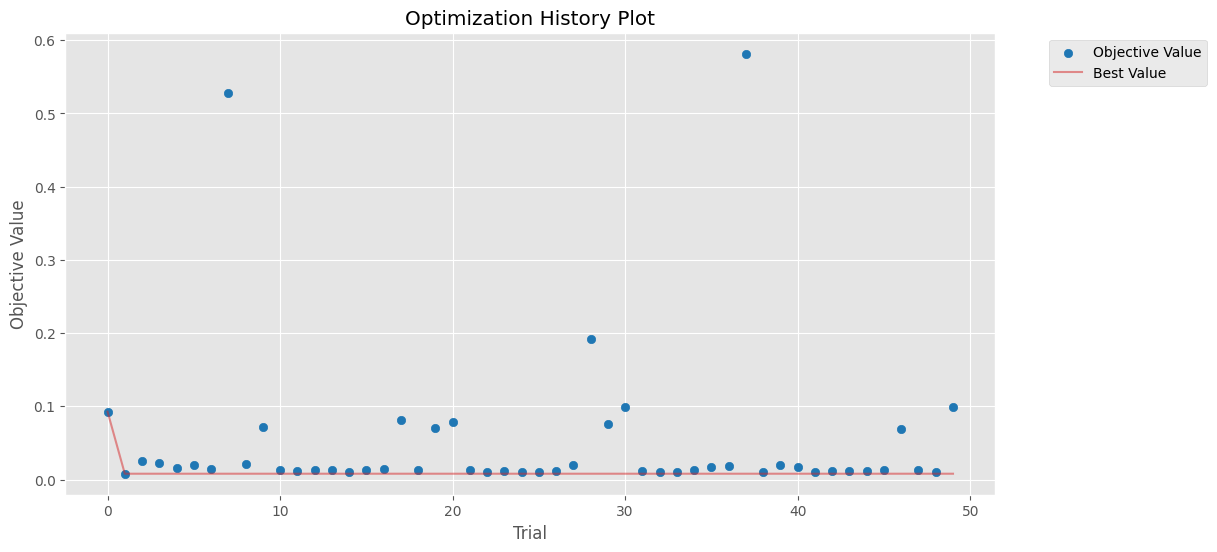

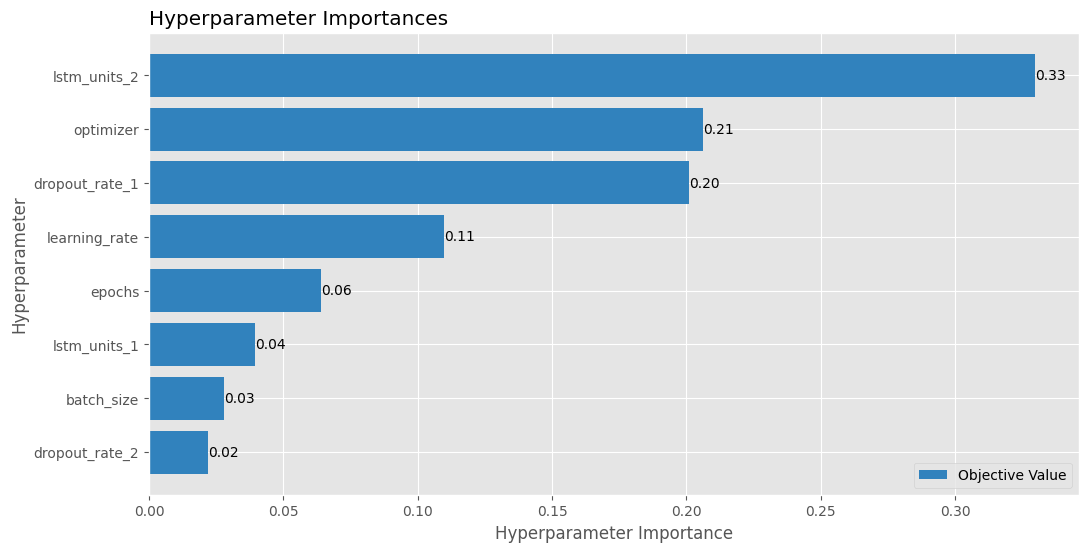

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.1146 - val_loss: 0.0025
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0243 - val_loss: 0.0025
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110 - val_loss: 0.0048
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0099 - val_loss: 0.0028
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0098 - val_loss: 0.0042
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - val_loss: 0.0034
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0107 - val_loss: 0.0031
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0076 - val_loss: 0.0027
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086 - val_loss: 0.0026
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094 - val_loss: 0.0038
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0073 - val_lo

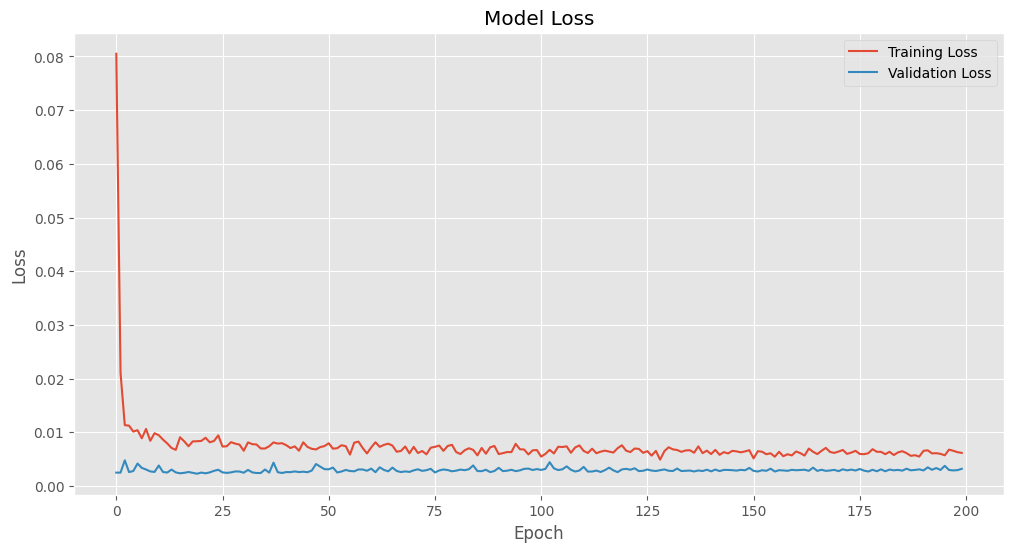

Average Loss: 0.0074


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 178.972
Root Mean Square Error: 246.869
Mean Absolute Percentage Error: 9.746%

evaluasi model data test:
Mean Absolute Error: 164.758
Root Mean Square Error: 216.721
Mean Absolute Percentage Error: 15.589%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

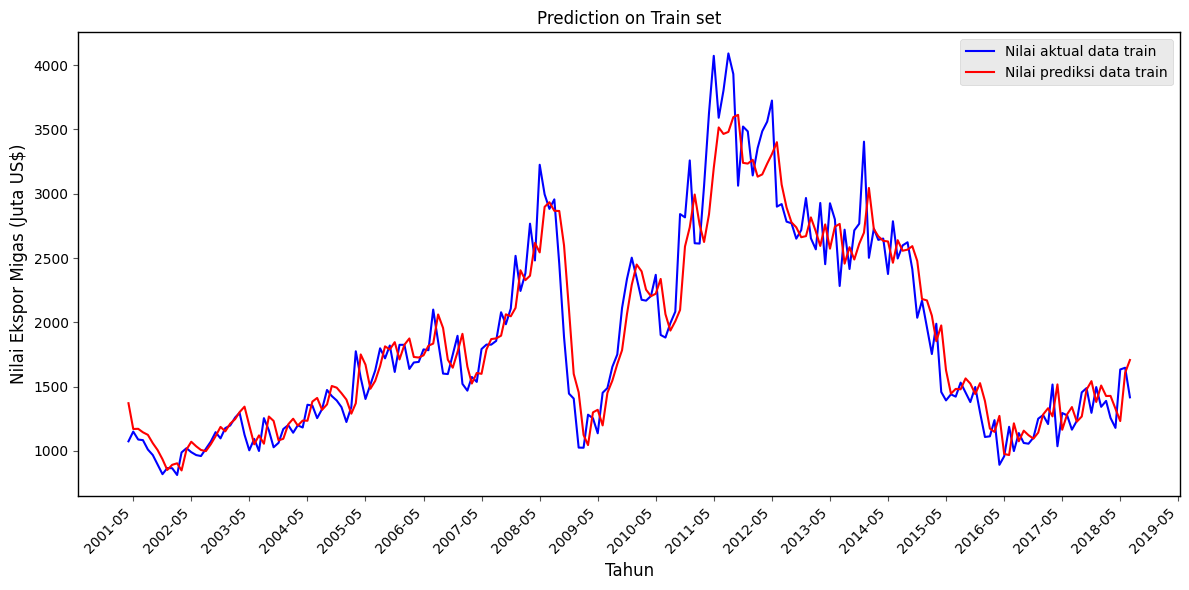

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

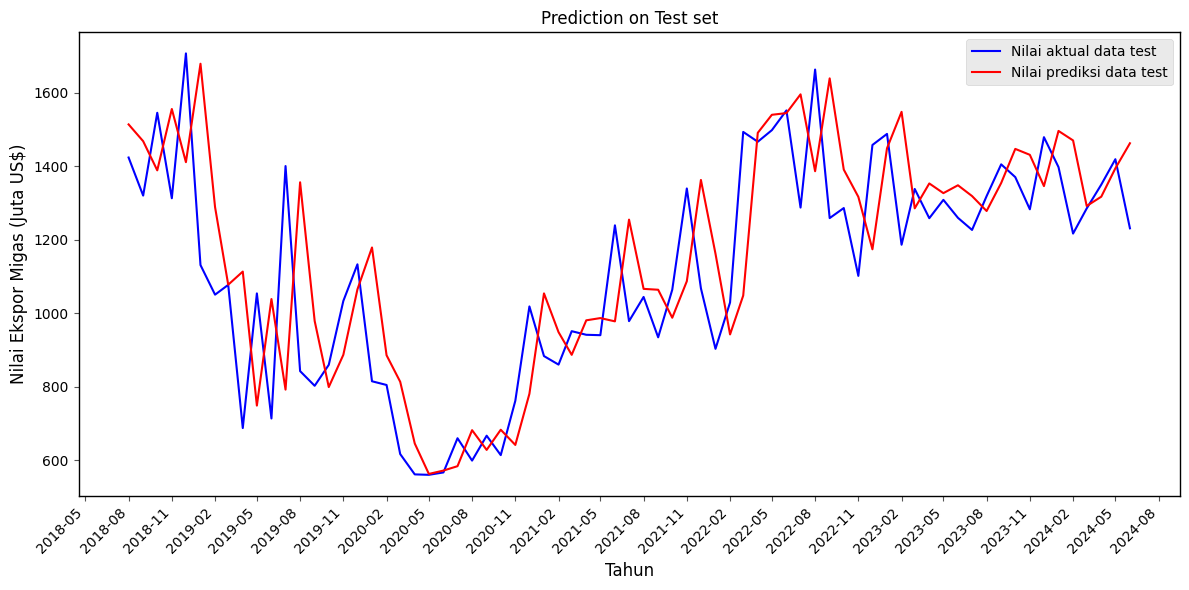

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

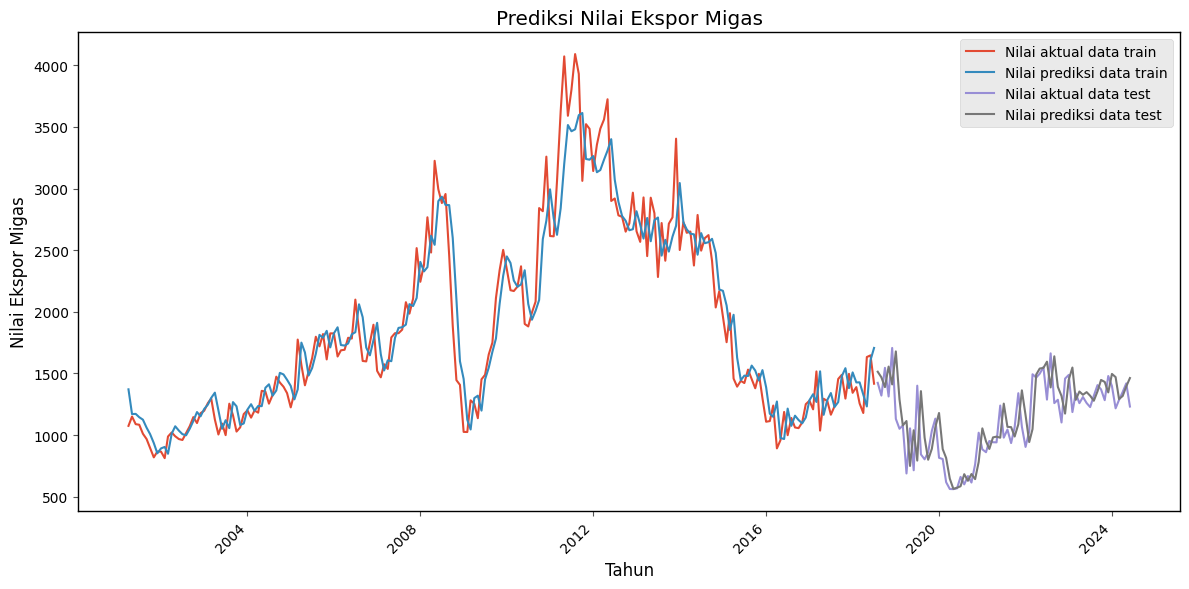

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-07-01                     1313.021851
1  2024-08-01                     1343.236328
2  2024-09-01                     1393.208252
3  2024-10-01                     1438.230713
4  2024-11-01                     1484.811890
5  2024-12-01                     1530.773438
6  2025-01-01                     1576.514771
7  2025-02-01                     1621.707886
8  2025-03-01                     1666.238525
9  2025-04-01                     1709.942261
10 2025-05-01                     1752

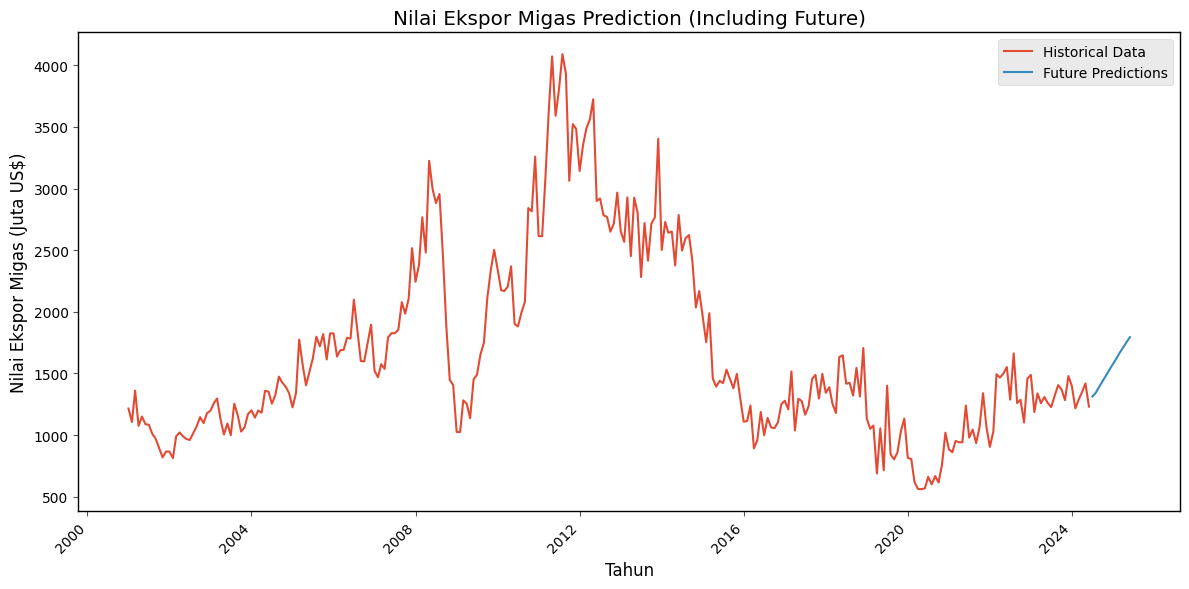

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()


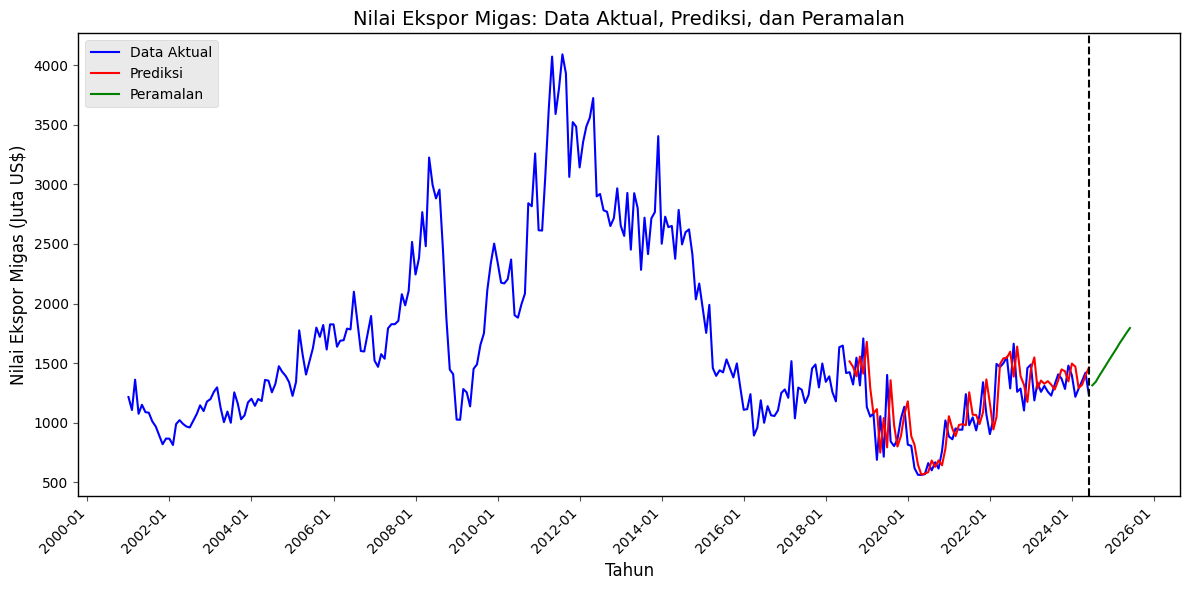

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [29]:
forecast_df.to_excel('forecast_2024-75:25_h2t3.xlsx', index=False)
from google.colab import files
files.download('forecast_2024-75:25_h2t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_2024-75:25_h2t3.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_2024-75:25_h2t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>